In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error as MSE
import wandb

In [2]:
class MyDataset(Dataset):
    def __init__(self):
        self.x = torch.linspace(-10,10,100).reshape(-1,1)
        self.y = 0.1 * self.x**4 + 1.2 * self.x**3 + 1.2 * self.x**2 + 2.1 * self.x 

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def plot(self):
        plt.scatter(self.x,self.y,color='r',s=0.1)

In [3]:
data = MyDataset()

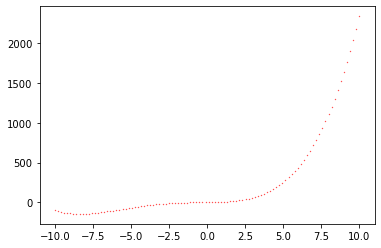

In [4]:
data.plot()

In [5]:
dataloader = DataLoader(data, batch_size=10, shuffle=True)

In [10]:
class MyModel(nn.Module):
    def __init__(self,size):
        super(MyModel, self).__init__()
        self.layers = torch.nn.Sequential(
            nn.Linear(1,size),      
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(size,1)
          )
        
    def forward(self,x):
        return self.layers(x)

In [11]:
my_model = MyModel(10000)

In [14]:
def train(epochs):
    
    #wandb.init(project='GNN',entity='tristanj')
    
    optimizer = torch.optim.Adam(my_model.parameters(),lr=0.001)
    
    best_score = None
    
    for epoch in tqdm(range(epochs)):
        
        my_model.train()
        
        running_loss = 0.
        
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            y_pred = my_model(batch_x)
            mse = ((y_pred - batch_y)**2).sum()
            running_loss = mse.item()
            mse.backward()
            optimizer.step()
          
        running_loss /= len(data)
        
        # When we compute the validation loss, it is critical not to tune the parameters
        my_model.eval()
        
        score = MSE(my_model(data.x).detach().numpy(),data.y)
        
        if not best_score:
            best_score = score
            torch.save(my_model, 'best-model.pt') 
        if score < best_score:
            best_score = score
            torch.save(my_model, 'best-model.pt')
        
        #wandb.log({"Train loss": running_loss, "Validation loss": score, "Best Validation loss": best_score})

In [16]:
train(10000)

  0%|          | 0/1 [00:00<?, ?it/s]

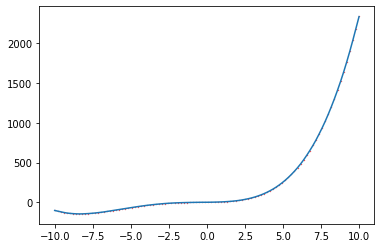

In [10]:
best_model = torch.load('best-model.pt')
data.plot()
plt.plot(data.x,best_model(data.x).detach().numpy())

There's some debate as to whether the dropout should be placed before or after the activation function. As a rule of thumb, place the dropout after the activate function for all activation functions other than relu.